<a href="https://colab.research.google.com/github/Junghyun1217/NLP-Embedding/blob/main/NLP_%EB%AC%B8%EC%9E%A5_%EC%9E%84%EB%B2%A0%EB%94%A9_%EA%B8%B0%EB%B0%98_%EA%B0%90%EC%84%B1_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install konlpy  # 한국어 자연어 처리를 위한 라이브러리
!pip install pandas
!pip install matplotlib seaborn
!pip install scikit-learn
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 41.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import urllib.request

# Naver 영화 리뷰 데이터셋 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 데이터 로드
train_data = pd.read_csv('ratings_train.txt', sep='\t')
test_data = pd.read_csv('ratings_test.txt', sep='\t')

print('훈련용 데이터 개수:', len(train_data))
print(train_data.head())

훈련용 데이터 개수: 150000
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


# 2단계: 데이터 전처리 및 토큰화 시작

In [4]:
# 1. 데이터 확인 및 결측치(NaN) 처리
print('--- 결측치 처리 전 ---')
print('리뷰 컬럼 결측치 유무:', train_data['document'].isnull().any())
# NaN 값이 포함된 행은 제거합니다.
train_data = train_data.dropna(how = 'any')

# 2. 텍스트 정규화 및 정제
import re

# 한글과 공백을 제외한 모든 문자(특수문자, 숫자 등)를 제거합니다.
# 이렇게 해야 모델이 순수한 한글 단어에만 집중할 수 있습니다.
train_data['document'] = train_data['document'].apply(lambda x: re.sub(r'[^가-힣\s]', '', str(x)))

# 내용이 모두 지워져 공백만 남은 행을 최종적으로 제거합니다.
train_data = train_data[train_data['document'].str.strip() != '']

print('\n--- 결측치 처리 후 ---')
print('최종 훈련 데이터 개수:', len(train_data))

--- 결측치 처리 전 ---
리뷰 컬럼 결측치 유무: True

--- 결측치 처리 후 ---
최종 훈련 데이터 개수: 148385


In [5]:
from konlpy.tag import Okt

# 형태소 분석기 준비
okt = Okt()

# 불용어 정의 (자주 사용되지만 감성 분석에 의미 없는 단어)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 토큰화 함수 정의
def tokenize_and_remove_stopwords(text):
    # 명사, 형용사 등 주요 품사만 추출하고, 단어의 원형(stem=True)으로 복원합니다.
    tokenized_text = okt.morphs(text, stem=True)

    # 불용어 제거
    result = [word for word in tokenized_text if not word in stopwords]
    return result

# 토큰화 함수를 훈련 데이터의 'document' 컬럼에 적용 (시간이 다소 걸릴 수 있습니다.)
train_data['tokenized'] = train_data['document'].apply(tokenize_and_remove_stopwords)

print('\n--- 토큰화 결과 확인 ---')
print(train_data[['document', 'tokenized']].head())


--- 토큰화 결과 확인 ---
                                            document  \
0                                  아 더빙 진짜 짜증나네요 목소리   
1                         흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나   
2                                  너무재밓었다그래서보는것을추천한다   
3                          교도소 이야기구먼 솔직히 재미는 없다평점 조정   
4  사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...   

                                           tokenized  
0                             [아, 더빙, 진짜, 짜증나다, 목소리]  
1       [흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]  
2                     [너, 무재, 밓었, 다그, 래서, 보다, 추천, 다]  
3               [교도소, 이야기, 구먼, 솔직하다, 재미, 없다, 평점, 조정]  
4  [사이, 몬페, 그, 익살스럽다, 연기, 돋보이다, 영화, 스파이더맨, 에서, 늙다...  


#정수 인코딩

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# --- (이하 정수 인코딩 및 패딩 코드 진행) ---

# 1. 정수 인코딩 (Integer Encoding) 시작
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

# 빈 리스트 제거 코드 재추가 (안정성을 위해)
# 2단계 토큰화 후 발생한 빈 리스트 행 제거
drop_index = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_index, axis=0)
y_train = np.delete(y_train, drop_index, axis=0)

print(f"빈 리스트 제거 후 훈련 데이터 개수: {len(X_train)}")

# 토크나이저 정의 및 훈련
tokenizer = Tokenizer(num_words = 30000)
tokenizer.fit_on_texts(X_train)

# 단어들을 정수 인덱스로 변환
X_train_encoded = tokenizer.texts_to_sequences(X_train)

# ... (이하 패딩 코드) ...
max_len = 30
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len, padding='post')

print('패딩 적용 후 훈련 데이터 모양:', X_train_padded.shape)

빈 리스트 제거 후 훈련 데이터 개수: 148370
패딩 적용 후 훈련 데이터 모양: (148370, 30)


#데이터 길이 통일

In [7]:
import matplotlib.pyplot as plt

# 리뷰 길이 분포 확인
print('\n--- 리뷰 길이 분석 ---')
print('리뷰 최대 길이:', max(len(review) for review in X_train_encoded))
print('리뷰 평균 길이:', sum(map(len, X_train_encoded))/len(X_train_encoded))

# 적절한 최대 길이 설정 (예: 30)
# 전체 데이터의 90% 이상을 포함하는 길이를 기준으로 정합니다.
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    # 설정한 길이 이하인 데이터의 비율 출력
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (count / len(nested_list))*100))

# 30 길이 이하인 샘플의 비율 확인
max_len = 30
below_threshold_len(max_len, X_train_encoded)

# 패딩 적용
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 모든 리뷰의 길이를 max_len(30)으로 통일합니다.
# 짧은 리뷰는 0을 채워 넣고 (padding='post'는 뒤에 채움), 긴 리뷰는 자릅니다.
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len, padding='post')

print('\n--- 패딩 결과 확인 ---')
print('패딩 적용 후 훈련 데이터 모양:', X_train_padded.shape)
print('첫 번째 리뷰 (패딩 적용):', X_train_padded[0])


--- 리뷰 길이 분석 ---
리뷰 최대 길이: 68
리뷰 평균 길이: 10.552941969400822
전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.43620678034644

--- 패딩 결과 확인 ---
패딩 적용 후 훈련 데이터 모양: (148370, 30)
첫 번째 리뷰 (패딩 적용): [ 50 448  16 252 650   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


#4단계: 모델 구축 및 학습 (LSTM with Embedding)
모델 구조 정의
TensorFlow/Keras 사용하여 Embedding → LSTM → Dense 구조의 분류 모델을 정의

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 이전 단계에서 설정한 변수들을 사용합니다.
vocab_size = 30000 + 1 # 단어 사전 크기 (0번 패딩 토큰 포함)
max_len = 30           # 문장 최대 길이
embedding_dim = 100    # 임베딩 벡터 차원 (100차원으로 설정)

# 모델 구축
model = Sequential()

# 1. Embedding Layer: 단어를 100차원 벡터로 변환합니다.
# input_dim: 단어 사전 크기 (vocab_size)
# output_dim: 임베딩 벡터 차원 (embedding_dim)
# input_length: 입력 시퀀스 길이 (max_len)
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

# 2. LSTM Layer: 순차적인 문맥 정보를 학습합니다.
model.add(LSTM(128)) # 128개의 은닉 유닛 사용

# 3. Output Layer: 최종 분류층 (긍정/부정 2개 클래스 중 하나를 예측)
# activation='sigmoid'는 이진 분류(0 또는 1)에 사용됩니다.
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy', # 이진 분류 손실 함수
              metrics=['accuracy'])

# 모델 구조 출력
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

훈련 및 결과 확인

In [9]:
# 모델 학습
# validation_split: 훈련 데이터 중 20%를 검증용으로 분리
history = model.fit(X_train_padded, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.7631 - loss: 0.4687 - val_accuracy: 0.8477 - val_loss: 0.3435
Epoch 2/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.8772 - loss: 0.2920 - val_accuracy: 0.8555 - val_loss: 0.3423
Epoch 3/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9049 - loss: 0.2330 - val_accuracy: 0.8522 - val_loss: 0.3589
Epoch 4/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.9266 - loss: 0.1849 - val_accuracy: 0.8499 - val_loss: 0.4071
Epoch 5/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.9422 - loss: 0.1465 - val_accuracy: 0.8474 - val_loss: 0.4777
Epoch 6/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9554 - loss: 0.1161 - val_accuracy: 0.8402 - val_loss: 0.5133
Epoch 7/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.9651 - loss: 0.0923 - val_accuracy: 0.8348 - val_loss: 0.7078
Epoch 8/10
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.9709 - loss: 0

#5단계: 테스트 및 시각화 (모델 평가 및 예측)
테스트 데이터 준비

In [10]:
# 1. 테스트 데이터 클리닝 (훈련 데이터와 동일한 방식 적용)
test_data = test_data.dropna(how = 'any') # 결측치 제거
test_data['document'] = test_data['document'].apply(lambda x: re.sub(r'[^가-힣\s]', '', str(x)))
test_data = test_data[test_data['document'].str.strip() != '']

# 2. 토큰화 (훈련 데이터에서 정의한 함수 사용)
test_data['tokenized'] = test_data['document'].apply(tokenize_and_remove_stopwords)

# 3. 정수 인코딩 (훈련 데이터의 'tokenizer' 객체 사용!)
# 이미 학습된 단어 사전(tokenizer)을 사용해야 일관성을 유지합니다.
X_test_encoded = tokenizer.texts_to_sequences(test_data['tokenized'].values)

# 4. 패딩 (훈련 데이터와 동일한 max_len=30 적용)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len, padding='post')
y_test = test_data['label'].values

print('테스트 데이터 패딩 후 모양:', X_test_padded.shape)

테스트 데이터 패딩 후 모양: (49430, 30)


모델 성능 평가

In [11]:
print('\n--- 모델 최종 성능 평가 ---')
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print('테스트 셋 손실(Loss): {:.4f}'.format(loss))
print('테스트 셋 정확도(Accuracy): {:.4f}'.format(accuracy))


--- 모델 최종 성능 평가 ---
테스트 셋 손실(Loss): 0.8508
테스트 셋 정확도(Accuracy): 0.8284


예측

In [12]:
def predict_sentiment(new_sentence):
    # 1. 텍스트 정제
    new_sentence = re.sub(r'[^가-힣\s]', '', new_sentence)

    # 2. 토큰화 (Okt 형태소 분석기 사용)
    tokenized_sentence = tokenize_and_remove_stopwords(new_sentence)

    # 3. 정수 인코딩 (훈련된 tokenizer 사용)
    encoded_sentence = tokenizer.texts_to_sequences([tokenized_sentence])

    # 4. 패딩 (max_len=30 적용)
    padded_sentence = pad_sequences(encoded_sentence, maxlen = max_len, padding='post')

    # 5. 모델 예측
    score = model.predict(padded_sentence, verbose=0)[0]

    # 6. 결과 출력
    if(score > 0.5):
        print(f"{new_sentence} -> 긍정 ({score[0]:.2f} 확률)")
    else:
        print(f"{new_sentence} -> 부정 ({(1-score)[0]:.2f} 확률)")

print('\n--- 사용자 문장 예측 테스트 ---')
predict_sentiment('이 영화 정말 최고예요. 다시 보고 싶어요!')
predict_sentiment('시간 낭비했어요. 스토리가 너무 엉성해요.')
predict_sentiment('배우들 연기는 좋았지만, 결말이 아쉽네요.')


--- 사용자 문장 예측 테스트 ---
이 영화 정말 최고예요 다시 보고 싶어요 -> 긍정 (1.00 확률)
시간 낭비했어요 스토리가 너무 엉성해요 -> 부정 (1.00 확률)
배우들 연기는 좋았지만 결말이 아쉽네요 -> 부정 (0.83 확률)


시각화

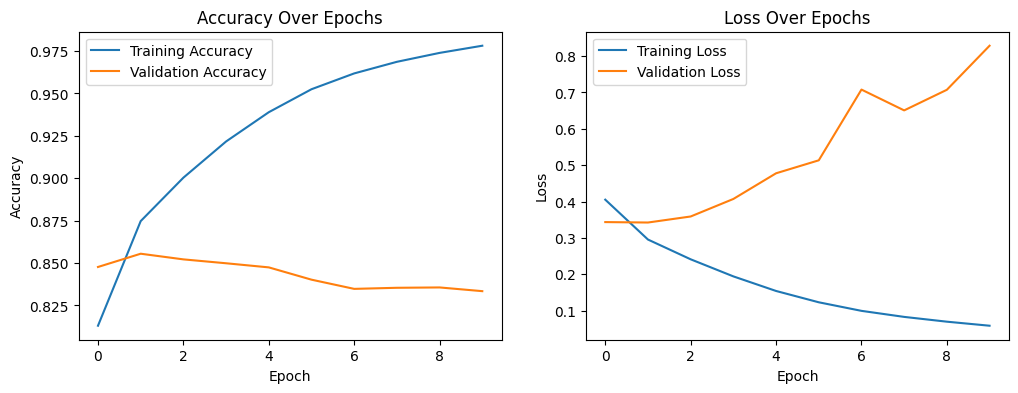

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실(Loss) 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()